In [1]:
import os
import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [9]:
def load_embeddings(subject):
    path = '../embeddings/' + subject
    normal_embs = np.load(path + '_normal.npy')
    sleepy_embs = np.load(path + '_sleepy.npy')
    
    return normal_embs, sleepy_embs

In [31]:
# Extracts average embedding in a segment from given embeddigs
def embeddings_segment(embeddings, video_len, segment_len):
    # The amount of frames at the end that are not taken into account
    rest = video_len % segment_len
    num_frames = video_len - rest
    avg_embeddings = []
    acum_embeddings = np.zeros(2048)
    # a blink is counted to a segment,when the blink starts in that segment
    for frame in range(num_frames + 1):
        # if frame % 1000 == 0:
        #     print(frame)
        acum_embeddings = acum_embeddings + np.array(embeddings[frame])
        # only happens at the end of a segment
        if frame % segment_len == 0 and frame != 0:
            avg_embeddings.append(acum_embeddings / segment_len)
            acum_embeddings = np.zeros(2048)
            #print('New segment: ', frame)
    return avg_embeddings

In [32]:
norm_embs, sleep_embs = load_embeddings('subject9')

print(len(norm_embs), len(sleep_embs))
avg_norm_embs = embeddings_segment(norm_embs, len(norm_embs), 46 * 60)
avg_sleep_embs = embeddings_segment(sleep_embs, len(sleep_embs), 46 * 60)

32016 42757


In [41]:
norm_len = len(avg_norm_embs)
sleep_len = len(avg_sleep_embs)

print(norm_len, sleep_len)

11 15


In [38]:
all_embs = avg_norm_embs + avg_sleep_embs
print(len(all_embs))

26


In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pri_comps = pca.fit_transform(all_embs)

pc_normal = pri_comps[:norm_len]
pc_sleep = pri_comps[norm_len:]

15


In [45]:
print(len(pc_normal[:,1]))

11


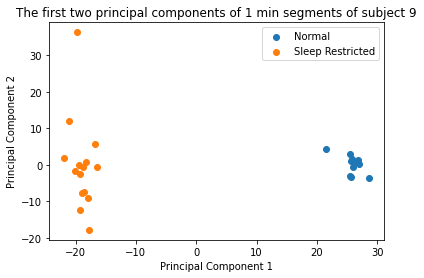

In [58]:
plt.scatter(pc_normal[:,0], pc_normal[:,1], label = 'Normal')
plt.scatter(pc_sleep[:,0], pc_sleep[:,1], label = 'Sleep Restricted')
#plt.scatter(pri_comps[:,0], pri_comps[:,1])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('The first two principal components of 1 min segments of subject 9')
plt.legend()
plt.savefig('pc_plot.jpg')
plt.show()